In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import time
import joblib
import torch
from torch import nn
import torch.optim as optim
import torch.utils.data as data

save_path = "../models/"

In [ ]:
X_train = pd.read_csv("../datasets/inputs/train/X_train.csv")
y_train = pd.read_csv("../datasets/inputs/train/y_train.csv")
X_val = pd.read_csv("../datasets/inputs/val/X_val.csv")
y_val = pd.read_csv("../datasets/inputs/val/y_val.csv")
X_test = pd.read_csv("../datasets/inputs/test/X_test.csv")
y_test = pd.read_csv("../datasets/inputs/test/y_test.csv")

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

train_dataset = data.TensorDataset(
    torch.FloatTensor(X_train.values).to(device),
    torch.FloatTensor(y_train.values).to(device),
)
val_dataset = data.TensorDataset(
    torch.FloatTensor(X_val.values).to(device),
    torch.FloatTensor(y_val.values).to(device),
)
test_dataset = data.TensorDataset(
    torch.FloatTensor(X_test.values).to(device),
    torch.FloatTensor(y_test.values).to(device),
)

batch_size = 1000
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=batch_size)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size)

Using device: cuda


In [21]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.leaky_relu = nn.LeakyReLU()
        self.input = nn.Linear(326, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.output = nn.Linear(64, 1)

        self.optimizer = optim.Adam(
            self.parameters(), lr=0.0001
        )  # Reduced learning rate
        self.criterion = nn.MSELoss()
        self.losses = {"train": [], "val": []}
        self.to(device)

    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.input(x)))
        x = self.leaky_relu(self.bn2(self.fc1(x)))
        x = self.leaky_relu(self.bn3(self.fc2(x)))
        x = self.leaky_relu(self.bn4(self.fc3(x)))
        x = self.output(x)
        return x

    def train_step(self, x, y):
        predictions = self(x)
        loss = self.criterion(predictions, y)

        self.optimizer.zero_grad()
        loss.backward()
        # Add gradient clipping
        torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
        self.optimizer.step()

        return loss.item()

    def fit(self, epochs=100):
        for _ in tqdm(range(epochs), desc="Training", unit="epoch"):
            for x_batch, y_batch in train_loader:
                loss = self.train_step(x_batch, y_batch)
            self.losses["train"].append(loss)
        return self.losses

    def evaluate(self):
        self.eval()
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                predictions = self(x_batch)
                loss = self.criterion(predictions, y_batch)
            self.losses["val"].append(loss.item())
        return self.losses

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            predictions = self(x)
        return predictions

    def save(self, name):
        joblib.dump(self.state_dict(), save_path + name)

    def load(self, name):
        self.load_state_dict(joblib.load(save_path + name))

    def plot_losses(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.losses["train"], label="Training Loss")
        plt.plot(self.losses["val"], label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Losses")
        plt.legend()
        plt.grid(True)
        plt.show()

Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Training: 100%|██████████| 10/10 [02:06<00:00, 12.69s/epoch]


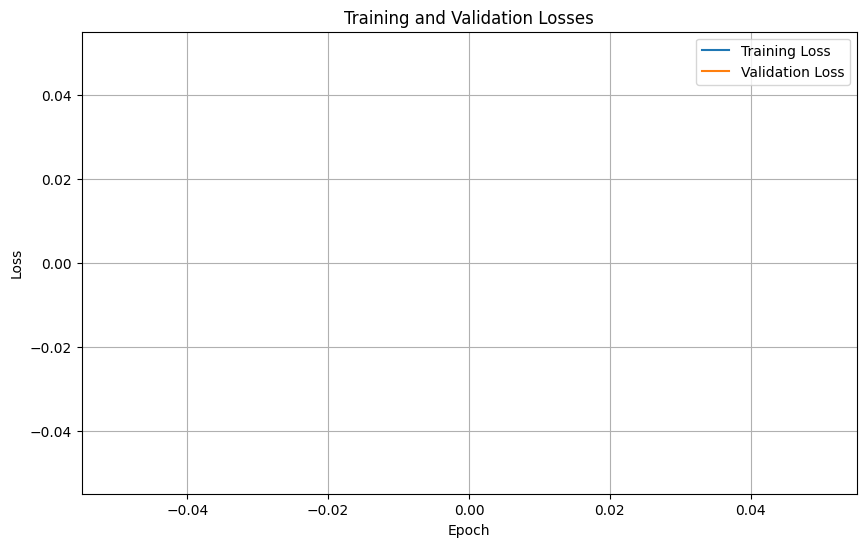

In [22]:
model = NeuralNetwork()
model.fit(epochs=10)
model.plot_losses()

In [23]:
print(model.losses)

{'train': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], 'val': []}
